# 01. Discrete-Time Markov Chain (DTMC)

In [1]:
# Packages imports

import sys
import os
sys.path.append(os.path.abspath(os.path.join('../..')))
sys.path.append(os.path.abspath(os.path.join('../')))
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(style='white')

## A. Motivation

The fundamental reason why Monte Carlo works at all for Bayesian statistical analysis is that it must follow Markov process, hence the name Markov-Chain Monte Carlo (MCMC). So if we want to understand MCMC to the fullest, it only makes sense if we understand Markov-Chain, at least what it is about. Shortly, Markov-Chain is a process where the probability to move to the next state only depends on the current state. The [Simulated Annealing for solving TSP](https://github.com/ridhoma/monte-cafe/blob/main/notebooks/02%20Simulated%20Annealing%20to%20Help%20The%20Salesman.ipynb) is one of Markov-Process example where the next proposed solution is the perturbation of current solution, which will be accepted/rejected by some probability. In essence, the probability of moving to the necxt proposed solution depends only on the current solution. The same principle applies to MCMC sampling algorithms, ultimately for Bayesian inference.


## B. The Markov Chain

Markov Chain is a **stochastic process** with **Markov property**. Let's break it down
-  **Process**: We can move from one step to another. Or in this context, we call it **state**
-  **Stochastic**: The transition to one state to another is **random**. There is a certain probability which states we will transition to next, including to stay at the current state (no transition)
-  **Markov properties**: The probability to move from the next state depends only on the current state, ignoring the history of what states we have been visited. This is also called **memoryless** property.

A Markov chain can be represented by a **stochastic transition matrix**. In essence, consider matrix $P$ where $P_{ij}$ is the probability of transitioning from state-$i$ (current state) to state-$j$. Of course it is obvious to see that $\sum_j P_{ij} = 1$.

In DTMC setting, the state transition happens at a fixed time interval. Simulating the process over certain number of timesteps $n$ allow us to calculate the probability of being in a particular state after $n$-steps. In other words, predicting the likelihood of the states in the future. A useful way to picture DTMC process is a **random walk on a graph**. Consider a graph with 3 nodes; A, B, C as figure below. The edge's values represent the stochastic matrix $P_{ij}$, probability to move to the next state. Note that there is a self-loop edge (i.e. `AA`, `BB`, and `CC`) whose values are non-zero which means there is non-zero probability to stay at the current state instead of moving to other state. 


In [2]:
# define the stochastic matrix
# variable Q and n_states in this cells is going to be reused in the following cells in this notebook
P = np.array([[0.55, 0.20, 0.25],  # A -> A, B, C
              [0.25, 0.50, 0.25],  # B -> A, B, C
              [0.15, 0.55, 0.30]]) # C -> A, B, C
n_states = P.shape[0] # there are 3 states

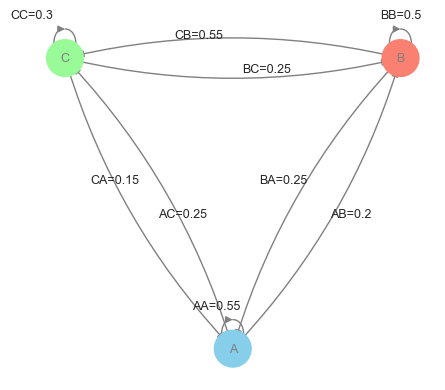

In [3]:
# Draw Markov-Chain as a Graph
from utils.viz_utils import draw_equilateral_triangle_markov_chain_graph

# Create a directed graph
node_labels = ["A", "B", "C"]
node_colors = ["skyblue", "salmon", "palegreen"]
nodes, edges = draw_equilateral_triangle_markov_chain_graph(P, node_labels, node_colors)
plt.show()

## C. Simulate Markov-Chain as Random Walk on A Graph

To simulate the random walk, first we set initial state `step=0` at $A$ (`index = 0`). Every next time step, we will take a random step to the next state (or stay at the same state) based on probability defined in the stochastic transition matrix $P$. We repeat the process until `max_steps` is reached. At each step we will keep track how many times each state has been visited since the beginning of the simulation. Why? Let's say just out of curiosity, but you will find it interesting later.

In [4]:
# Markov Chain simulation as random walks
from utils.utils import count_frequency
def random_walks(P, max_steps):
    """
    Run Markov-Chain as a random walk on graph
    P: numpy array. m x m matrix where m is number of states
    max_stes: integer. number of steps
    """
    n_states = P.shape[0]
    current_state = np.random.choice(n_states) # start at random node
    states = [] # list to keep track the visited states in each iteration
    freq = [] # list to keep track how many times each states has been visited. Initial value is 1 for state-A
    for step in range(max_steps + 1):
        states.append(current_state) # keep track of the current state
        # count the frequency of visit of each state
        f_ = count_frequency(states)
        f = np.zeros(n_states)
        for k,v in f_.items():
            f[k] = v  
        freq.append(f)
        #  random walk to next node according to Q, and update current_state
        current_state = np.random.choice(n_states, p=P[current_state])
    
    # return as numpy array
    return np.array(freq), np.array(states)

In [5]:
max_steps = 4000
freq_evolution, states = random_walks(P, max_steps=max_steps)
freq_evolution_normed = freq_evolution/freq_evolution.sum(axis=1, keepdims=True) # normalized the frequency so that the sum is 1.0 (100%)

The cell below visualizes the simulation we just did above. You can navigate the animation interactively and analyze each plot. There are 3 plots;

**1. The random walk on Graph**  
    This graph visualizes the random walk we simulate above. When we arrive at a state the state will turn on, and will turn off when we left it.
   
**2. The frequency distribution (bar chart)**  
    At each time step, we count how many times the state has been visited from the beginning of the simulation (`step=0`) until the current `step`.
    
**3. The evolution of frequency distribution over time (line chart)**  
    Plotting each frequency values as a line chart where the x-axis is the time step

What do you think is interesting here?

/var/folders/6j/qp_lv_2j4gb6nqctf9lsp6lh0000gn/T/ipykernel_30954/2770108471.py:70: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  anim.save("outputs/03_markov_chain_as_random_walk_on_graph.mp4", writer="ffmpeg", fps=20)
/Users/ridhoakbar/Library/Caches/pypoetry/virtualenvs/monte-cafe-PGp5TrUp-py3.11/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.canvas.print_figure(bytes_io, **kw)


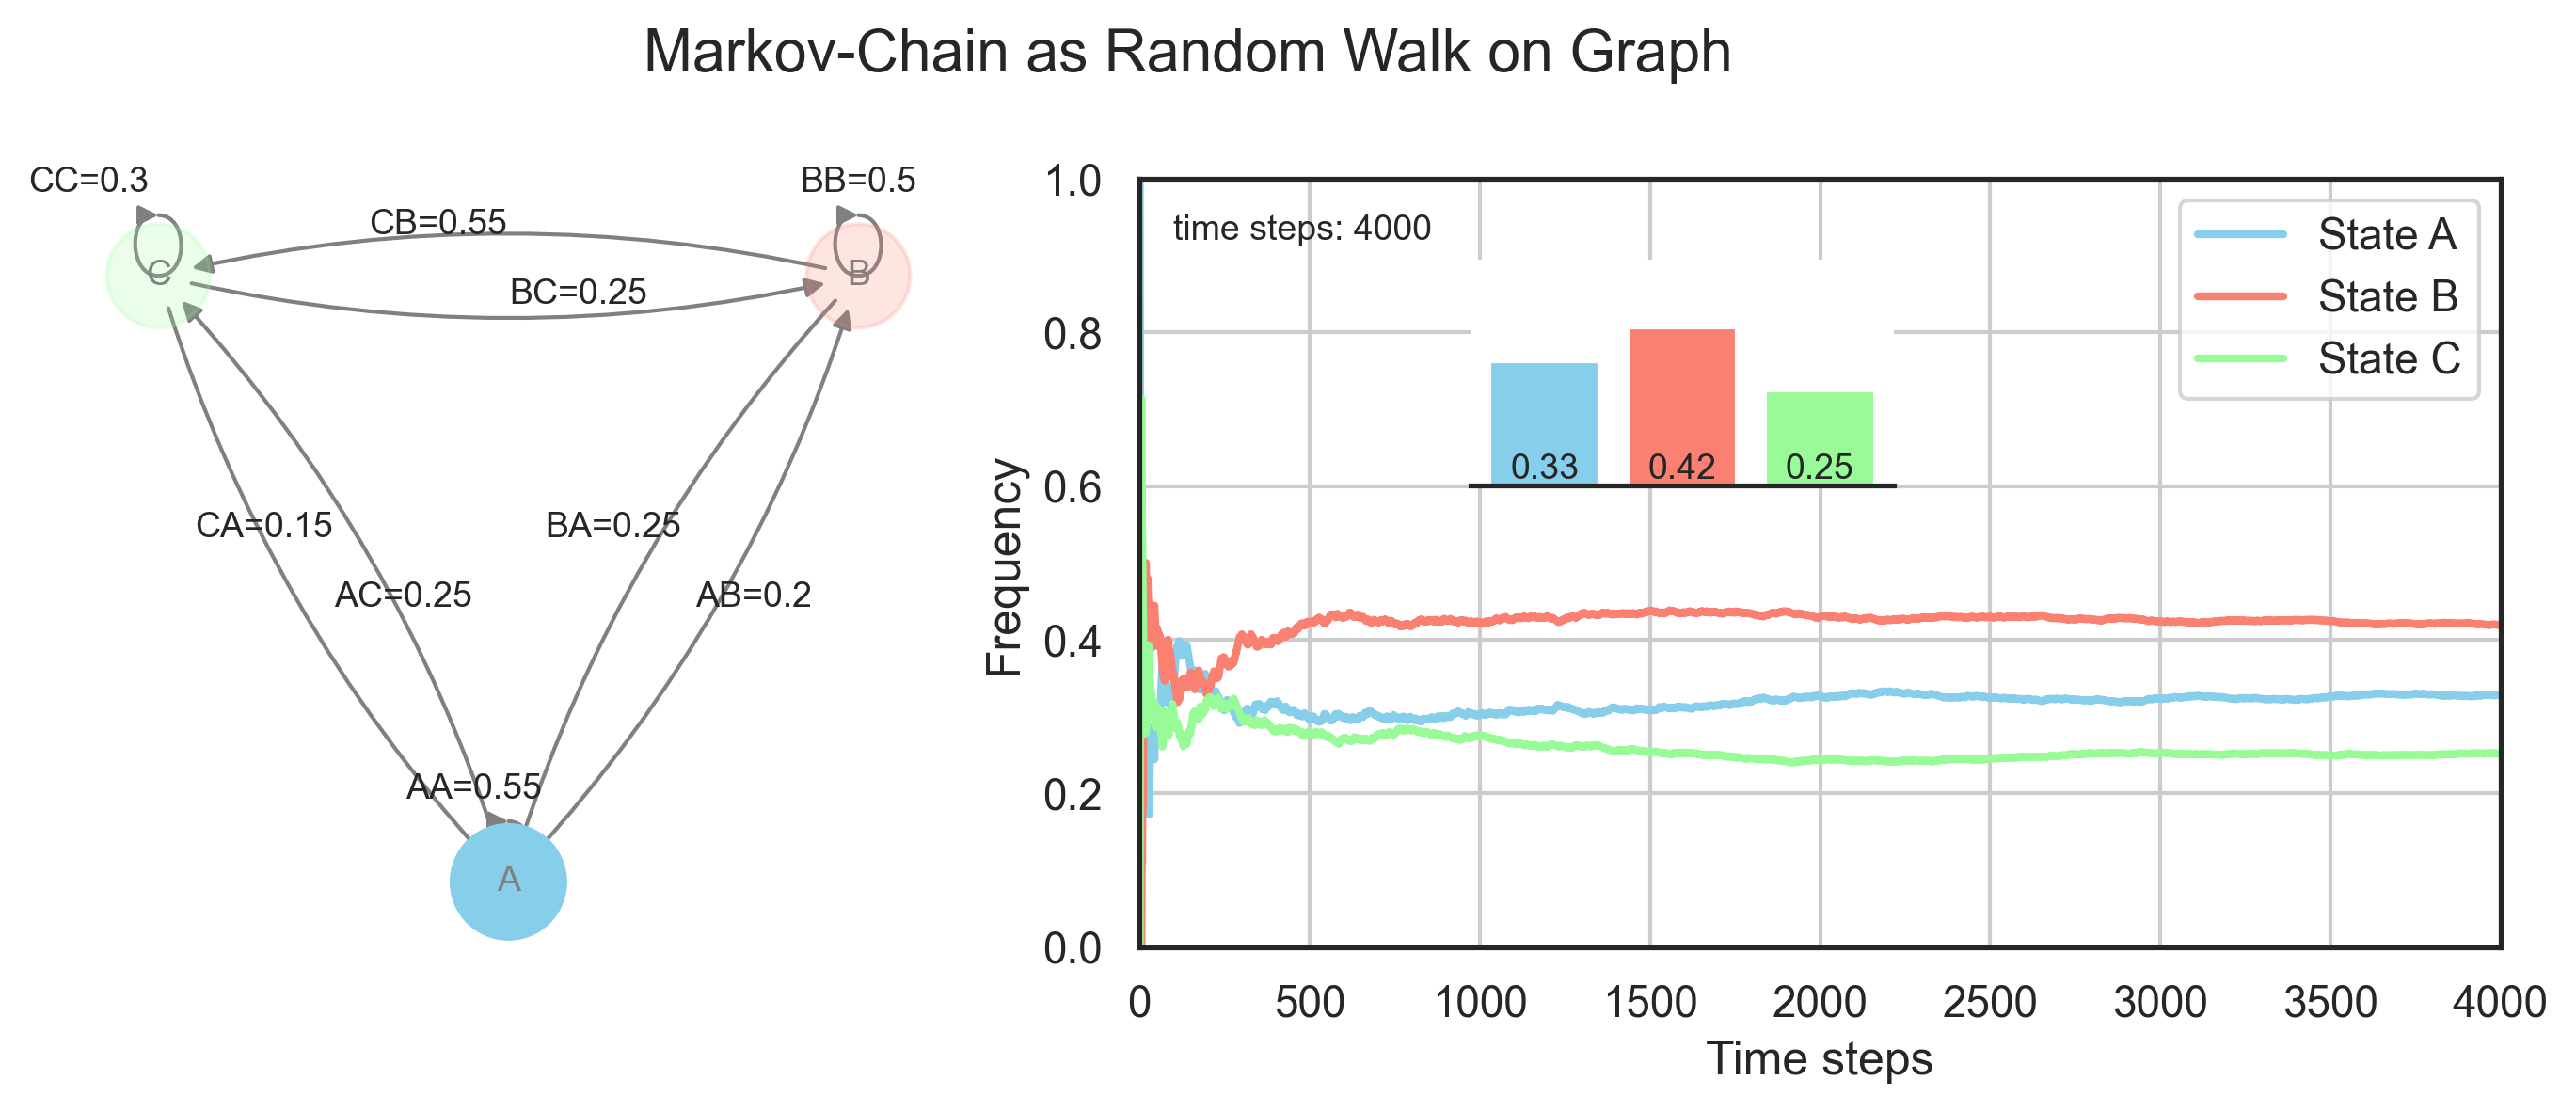

In [6]:
# Visiualizing and animating the simulation. Run this cell to animate the simulation (It will take a while)

import matplotlib.gridspec as gridspec
from matplotlib.animation import FuncAnimation
from IPython.display import HTML
import matplotlib
matplotlib.rcParams['animation.embed_limit'] = 512

fig = plt.figure(tight_layout=True, figsize=(10,4))
fig.dpi = 300
fig.suptitle(f"Markov-Chain as Random Walk on Graph", fontsize=15)

grid = gridspec.GridSpec(1, 2)
ax_netx = fig.add_subplot(grid[0, 0])
ax_line = fig.add_subplot(grid[0, 1])
ax_bars = fig.add_axes([0.6, 0.575, 0.15, 0.2]) # inset axes

node_labels = ["A", "B", "C"]
node_colors = ["skyblue", "salmon", "palegreen"]

# Draw the Graph
[nodes, edges] = draw_equilateral_triangle_markov_chain_graph(P, node_labels=node_labels, node_colors=node_colors, ax=ax_netx)
bars = ax_bars.bar(range(n_states), np.zeros(n_states), color=node_colors)
# ax_netx.set_title("Markov Process as Random Walk on Graph")

# plot histogram of the states distribution
ax_bars.set_xticks([])
ax_bars.set_yticks([])
ax_bars.set_ylim([0,0.6])
ax_bars.spines[['left', 'right', 'top']].set_visible(False)
bars_labels = ax_bars.bar_label(bars, labels=[f"{pi:.2f}" for pi in freq_evolution_normed[0]], fontsize=9)

# plot line of the states distribution evolution over time
lines = []
for i in range(n_states):
    label = f"State {node_labels[i]}"
    lines.append(
        ax_line.plot([], [], lw=2, c=node_colors[i], label=label)[0]
    )
ax_line.set_ylabel("Frequency")
ax_line.set_ylim([0, 1])
ax_line.set_xlabel("Time steps")
ax_line.set_xlim([0, max_steps])
ax_line.legend()
ax_line.grid()
ts_text = ax_line.annotate(f"time steps: {0}", fontsize=9, xy=(100,0.92))

# animate the Markov-process
n_frames = 220
t_sampled = np.linspace(0, max_steps-1, n_frames).astype(int)
def update_frequency_distribution(frame):
    t = t_sampled[frame]
    nodes_sizes = [700]*3
    nodes_alphas = [0.2]*3
    nodes_sizes[states[t]] = nodes_sizes[0]*1.2
    nodes_alphas[states[t]] = 1
    nodes.set(sizes=nodes_sizes, alpha=nodes_alphas)
    for i in range(n_states):
        bars.patches[i].set_height(freq_evolution_normed[t][i])
        bars_labels[i].set(text=f"{freq_evolution_normed[t][i]:.2f}", fontsize=9)
        lines[i].set_data(np.arange(t), freq_evolution_normed[:t, i])
    ts_text.set_text(f"time steps: {t+1}")
    return [nodes] + bars.patches + lines
    
# PICK HOW TO DISPLAY THE SIMULATION

# Save animation as file
# plt.close(fig)
anim = FuncAnimation(fig, update_frequency_distribution, frames=n_frames, repeat=False, blit=False)
anim.save("outputs/03_markov_chain_as_random_walk_on_graph.mp4", writer="ffmpeg", fps=20)

# Plot only the last frame of the animation
update_frequency_distribution(frame=n_frames - 1)
plt.show()


## D. Stationary Distribution

From the figure above we can see the dynamics of the frequency distribution over time. During the early times of the simulation, the frequency distribution fluctuates. But after about 500 iteration, state B constantly having the higest freqeuency, followed by state A, and state C. And when we run the simulation longer, all 3 lines converge into some frequency values,
```
State A: 0.32 | State B: 0.42 | State C: 0.26
```
Thiese values are called _**stationary distribution**_, i.e. the distribution of the frequence at stationary time (unchanged over time).

So despite the beginning of the process is very unpredictable, given enough repetitions the outcome is predictable. In fact, the stationary distribution only depends on the stochastic transition matrix $P$ and we can calculate the stationary distribution exactly from $P$.

Let $\pi$ be a frequency distribution over states from a markov chain with stochastic transition matrix $P$. $\pi$ is stationary if and only if this equation is true 
$$
\pi P = \pi
$$
which can be rewritten as 
$$
\pi(P - I) = 0
$$
where $I$ is identity matrix. We also know that $\sum_{i}\pi_i = 1$ because the frequency of all the states should sum up to 100%. From here, we can build a system of linear equations;
$$
\begin{bmatrix}P^T - I\\1\end{bmatrix} 
\cdot
\begin{bmatrix}\pi^T\end{bmatrix}
= 
\begin{bmatrix}0\\1\end{bmatrix} 
$$

let's solve this with numpy

In [8]:
def calculate_stationary_distribution(P):
    # system of linear equations A.x = b, solve for x
    A = P.T - np.eye(P.shape[0])
    A = np.vstack((A, np.ones(P.shape[0])))
    b = np.zeros(P.shape[0])
    b = np.append(b, 1)
    pi = np.linalg.lstsq(A, b, rcond=None)[0]
    return pi

pi = calculate_stationary_distribution(P)
print(f"Stationary distribution: State-A: {pi[0]:.2f} | State-B: {pi[1]:.2f} | State-C: {pi[2]:.2f}")

Stationary distribution: State-A: 0.32 | State-B: 0.42 | State-C: 0.26


In order to reacah stationary distribution, a Markov-Chain must meet 2 conditions
1. Irreducible: every state can be reached from any other state.
2. Aperiodic: the chain does not cycle through states in a fixed period

If any of these conditions are not met, the stationary distribution will not be achieved

## E. Reducable and Periodic Chains

### Reducible Markov Chain with Absorbing State
Below are example of reducible Markov-Chain where there is no way to move from other state, once we fall into states-C. We say that state-C is an absorbing state. Mrkov-process on a chain with abosrbing states will result in distribution where all other states are 0, and the absorbing states get all the frequency or density.

$$
P = 
\begin{bmatrix}
0 & 0.99 & 0.01 \\
0.99 & 0 & 0.01 \\
0 & 0 & 1 \\
\end{bmatrix}
$$

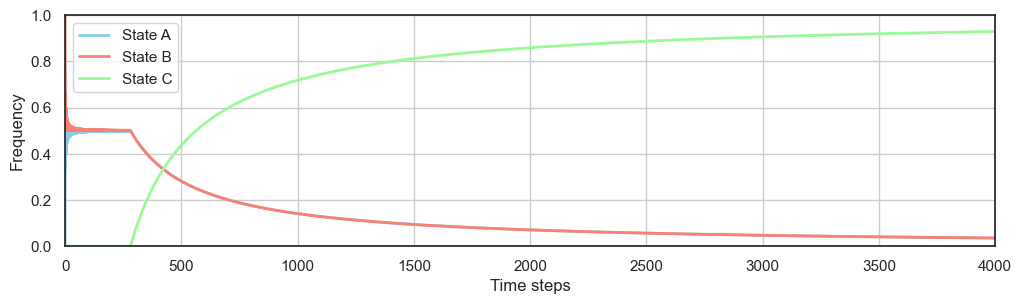

In [9]:
# Random walk on a reducible Markov-Chain

P = np.array([[0, 0.99, 0.01],  # A -> A, B, C
              [0.99, 0, 0.01],  # B -> A, B, C
              [0.0, 0.0, 1]]) # C -> A, B, C

max_steps = 4000
freq_evolution, states = random_walks(P, max_steps=max_steps)
freq_evolution_normed = freq_evolution/freq_evolution.sum(axis=1, keepdims=True) # normalized the frequency so that the sum is 1.0 (100%)

# Plot the visit frequency distribution
fig, ax = plt.subplots(figsize=(12,3))
lines = []
for i in range(n_states):
    label = f"State {node_labels[i]}"
    lines.append(
        ax.plot(freq_evolution_normed[:,i], lw=2, c=node_colors[i], label=label)[0]
    )
ax.set_ylabel("Frequency")
ax.set_ylim([0, 1])
ax.set_xlabel("Time steps")
ax.set_xlim([0, max_steps])
ax.legend()
ax.grid()

### Periodic Markov Chain

Below are example of periodic Markov-Chain. It is periodic because every 3 steps, it will always go back to it's original state. For example if we start from state-A, there is 100% probability to move to state-B, then 100% to move to state-C, then 100% to move back to state-A before repeating the process. Looking at the distribution over time, it never reaches stationary. Instead it is oscillating to infinity.

$$
P = 
\begin{bmatrix}
0 & 1 & 0 \\
0 & 0 & 1 \\
1 & 0 & 0 \\
\end{bmatrix}
$$

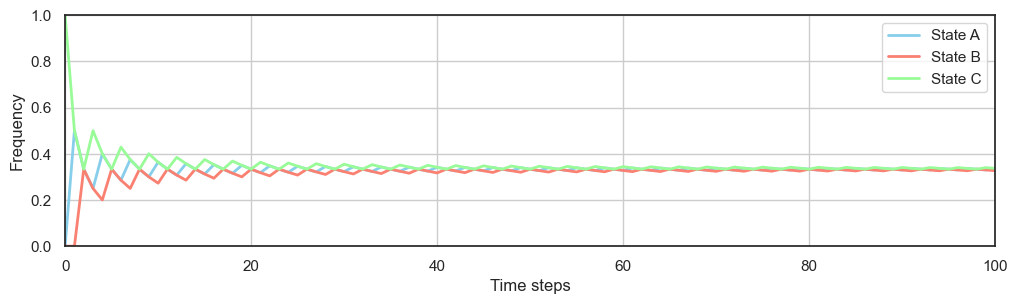

In [10]:
# Random walk on a Periodic Markov-Chain

P = np.array([[0, 1, 0],  # A -> A, B, C
              [0, 0, 1],  # B -> A, B, C
              [1, 0, 0]]) # C -> A, B, C

max_steps = 100
freq_evolution, states = random_walks(P, max_steps=max_steps)
freq_evolution_normed = freq_evolution/freq_evolution.sum(axis=1, keepdims=True) # normalized the frequency so that the sum is 1.0 (100%)

# Plot the visit frequency distribution
fig, ax = plt.subplots(figsize=(12,3))
lines = []
for i in range(n_states):
    label = f"State {node_labels[i]}"
    lines.append(
        ax.plot(freq_evolution_normed[:,i], lw=2, c=node_colors[i], label=label)[0]
    )
ax.set_ylabel("Frequency")
ax.set_ylim([0, 1])
ax.set_xlabel("Time steps")
ax.set_xlim([0, max_steps])
ax.legend()
ax.grid()

# Reflections

The purpose of MCMC is to draw samples as representative as possible to target distribution. We do it by repeatedly proposing a sample and accepting/rejecting them based on certain criteria. In order for us to be sure that we will ever reach the target distribution, we must make sure that our proposal generation process follows Markov-Process because then, the process will converge to stationary distribution (i.e. our target distribution) given sufficient number of repetition.

But actually, not all $P$ will converge to a useful stationary distribution. Only when the Markov-Chain is irreducible and aperiodic, the process will lead to a useful stationary outcomes. When developing the sampling algorithm for MCMC, we must ensure these conditions are met. There is another stronger condition that is a fundamental in developing MCMC sampling algorithm, namely **reversibility** which may result in a condition called Detailed Balance. This condition is used in developing Metropolis-Hasting sampling algorithm. We shall discuss in separate notebnook.

# End of the notebook